In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

% matplotlib inline

UsageError: Line magic function `%` not found.


* [Odorant to $Ca^{2+}$ signal](#odor)

* [LNK biophysical kinetic model](#LNK)

* [Spike-response model](#SRM)

## Odorant to $Ca^{2+}$ signal <a name="odor"></a>

https://www.sciencedirect.com/science/article/pii/S089662731301088X

$\frac { d A } { d t } = - k _ { a } A + I(t$

$\frac { d F } { d t } = - k _ { f } F + k _ { a f } A$

$\frac { d S } { d t } = - k _ { s } S - k _ { a s } A$

$R= F + S$

Analytic calculation via Laplace transformation $L\{f(t)\}(s)$

### $K(t) = \frac { k _ { a f } e ^ { - k _ { f } t } } { k _ { a } - k _ { f } } - \frac { k _ { a s } e ^ { - k _ { s } t } } { k _ { a } - k _ { s } } + \frac { \left( k _ { a f } \left( k _ { s } - k _ { a } \right) - k _ { a s } \left( k _ { f } - k _ { a } \right) \right) e ^ { - k _ { a } t } } { \left( k _ { a } - k _ { f } \right) \left( k _ { a } - k _ { s } \right) }$

In [2]:
ka = 1/2.99
kf = 1/0.04
ks = 1/10.88
kas = 0.0024
kaf = 1  #ralative value to kas...

Text(0, 0.5, 'Kernel')

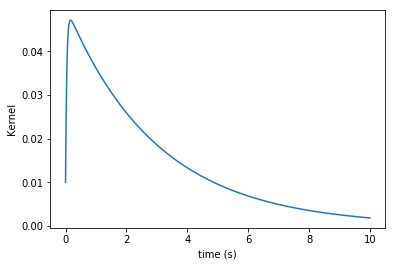

In [3]:
### analytic solution
time = 10  #sec
dt = 0.01  #~10ms
tk = np.arange(0,time,dt)
Kt = kaf/(ka-kf)*np.exp(-kf*tk) - kas/(ka-kf)*np.exp(-ks*tk) + (kas/(ka-ks) - kaf/(ka-kf))*np.exp(-ka*tk)
plt.plot(tk,Kt)
plt.xlabel('time (s)')
plt.ylabel('Kernel')

In [10]:
## noise input
time = 200  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)

M = np.array([[-ka, 0, 0],[kaf, -kf, 0],[-kas, 0, -ks]])  #linear response matrix
state = np.zeros((3,len(t)))  #all three states
R = np.zeros(len(t))  #output

for tt in range(0,len(t)-1):
    state[:,tt+1] = state[:,tt] + dt*(M @ state[:,tt]) + np.array([np.random.randn(),0,0])
    R[tt] = sum(state[1:,tt])

Text(0, 0.5, 'output')

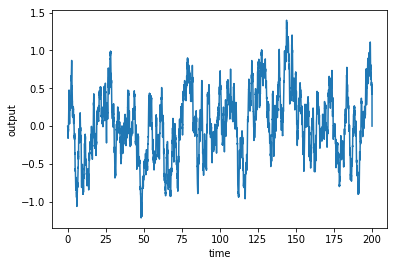

In [11]:
plt.plot(t,R)
plt.xlabel('time')
plt.ylabel('output')

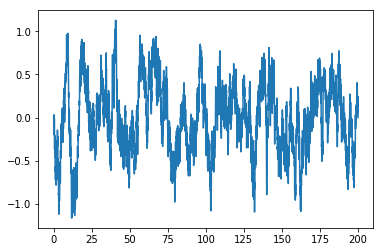

In [15]:
## periodic input
time = 200  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)

M = np.array([[-ka, 0, 0],[kaf, -kf, 0],[-kas, 0, -ks]])  #linear response matrix
state = np.zeros((3,len(t)))  #all three states
R = np.zeros(len(t))  #output

f = 5  #frequency  (5Hz for 200ms flickering)
In = np.cos(t*(2*np.pi)*f)*1 + 1*np.random.randn(len(t))

for tt in range(0,len(t)-1):
    state[:,tt+1] = state[:,tt] + dt*(M @ state[:,tt]) + np.array([In[tt],0,0])
    R[tt] = sum(state[1:,tt])
    
plt.plot(t,R)

In [16]:
## infer effective kernel
win = len(Kt)  #kernel width
X = np.zeros((len(t)-win,win))

#design matrix
for xx in range(0,X.shape[0]):
    X[xx,:] = In[xx:xx+win]

In [17]:
#regression
Kest = np.linalg.inv(X.T @ X) @ X.T @ R[win:]

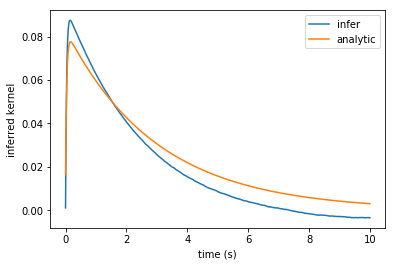

In [18]:
plt.plot(tk,np.flip(Kest)/np.linalg.norm(Kest),label='infer')
plt.xlabel('time (s)')
plt.ylabel('inferred kernel')
plt.plot(tk,Kt/np.linalg.norm(Kt),label='analytic')
plt.legend()

## LNK biophysical kinetic model  <a name="LNK"></a>

(linear-nonlinear-kinetic)  https://www.sciencedirect.com/science/article/pii/S0896627312000797

$\frac { d \mathbf { P } ^ { \mathrm { T } } ( t ) } { d t } = \left( \begin{array} { c } { \dot { P } _ { 1 } ( t ) } \\ { \dot { P } _ { 2 } ( t ) } \\ { \dot { P } _ { 3 } ( t ) } \\ { \dot { P } _ { 4 } ( t ) } \end{array} \right)$

$=\mathbf { P } ^ { \mathrm { T } } ( t ) \left( \begin{array} { c c c c } { - u ( t ) k _ { a } } & { u ( t ) k _ { a } } & { 0 } & { 0 } \\ { 0 } & { - k _ { f i } } & { k _ { f i } } & { 0 } \\ { k _ { f r } } & { 0 } & { - \left( k _ { f r } + k _ { s i } \right) } & { k _ { s i } } \\ { 0 } & { 0 } & { u ( t ) k _ { s r } } & { - u ( t ) k _ { s r } } \end{array} \right)$

In [388]:
## kinetic rates (parameters for RGC...)
ka = 39
kfi = 45
kfr = 1.4
ksi = 6.
ksr = 1.

In [395]:
## LNK states driven by noise
time = 200  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)
state = np.zeros((4,len(t)))  #all three states

#stimulus
f = 0.5  #frequency  (5Hz for 200ms flickering)
In = (np.cos(t*(2*np.pi)*f)*0 + 0.1*np.random.randn(len(t)))*0.5

#linear
def K(alpha,t):
    D = alpha*np.exp(-alpha*t)*((alpha*t)**5/math.factorial(5) - (alpha*t)**7/math.factorial(7))
    return D

#nonlinear
def N(u,threshold):
    R = np.exp(u-threshold)
    return R

alpha = 5
threshold = 3.
tw = np.arange(0.1,5,0.1) 
win = len(tw)
lin = np.zeros(len(t))
u = np.zeros(len(t))
state[:,len(tw)] = np.random.rand(4)*1  #initial condition (?)
#dynamics
for tt in range(len(tw),len(t)-1):
    lin[tt] = np.dot(K(alpha,tw),In[tt-win:tt])
    u[tt] = N(lin[tt],threshold)
    MM = np.array([[-u[tt]*ka,u[tt]*ka,0,0],[0,-kfi,kfi,0],[kfr,0,-(kfr+ksi),0],[0,0,u[tt]*ksr,-u[tt]*ksr]])
    state[:,tt+1] = state[:,tt] + dt*(MM @ state[:,tt])

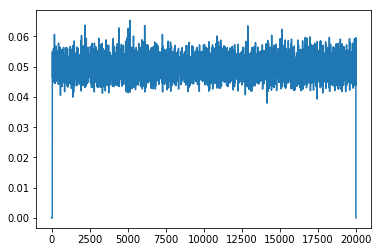

In [396]:
plt.plot(u)

Text(0, 0.5, 'state value')

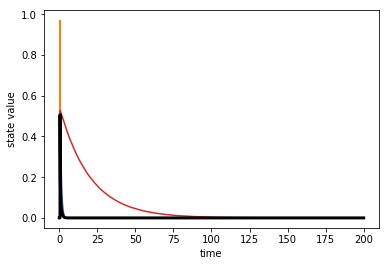

In [397]:
plt.plot(t,state.T);
plt.plot(t,state[2,:],linewidth=3,color='k')
plt.xlabel('time')
plt.ylabel('state value')

Text(0, 0.5, 'inferred kernel')

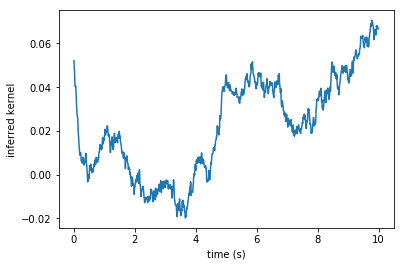

In [13]:
### effective kernel??
#perhaps this is an adaptive nonlinearity problem...

## infer effective kernel
win = len(Kt)  #kernel width
X = np.zeros((len(t)-win,win))

#design matrix
for xx in range(0,X.shape[0]):
    X[xx,:] = In[xx:xx+win]
    
#regression
Kest = np.linalg.inv(X.T @ X) @ X.T @ state[2,win:]

plt.plot(tk,np.flip(Kest)/np.linalg.norm(Kest))
plt.xlabel('time (s)')
plt.ylabel('inferred kernel')

In [14]:
## eigenvalue as a function of input

es = []
Is = np.arange(0,1,0.1)
for ii in Is:
    MM = np.array([[ii*ka,ii*ka,0,0],[0,-kfi,kfi,0],[kfr,0,-(kfr+ksi),0],[0,0,ii*ksr,ii*ksr]])
    e,v = np.linalg.eig(MM)
    es.append(e)

Text(0, 0.5, 'time scale (eigen-value)')

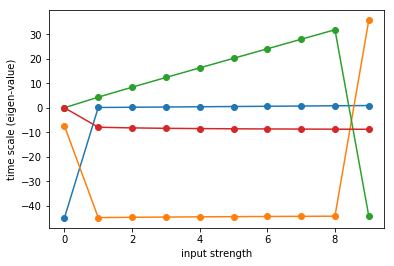

In [15]:
plt.plot(np.array(es),'-o');
plt.xlabel('input strength')
plt.ylabel('time scale (eigen-value)')

In [209]:
#... Multiplicative GLM needed!

Text(0, 0.5, 'Kernel')

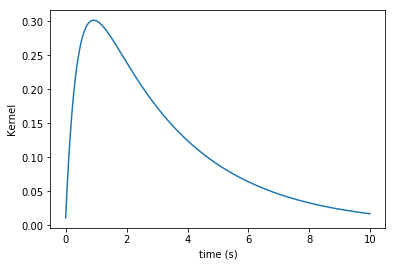

In [29]:
ka = 1/2.99
kf = 1/0.4
ks = 1/10.88
kas = 0.0024
kaf = 1  #ralative value to kas...

### analytic solution
time = 10  #sec
dt = 0.01  #~10ms
tk = np.arange(0,time,dt)
Kt = kaf/(ka-kf)*np.exp(-kf*tk) - kas/(ka-kf)*np.exp(-ks*tk) + (kas/(ka-ks) - kaf/(ka-kf))*np.exp(-ka*tk)
plt.plot(tk,Kt)
plt.xlabel('time (s)')
plt.ylabel('Kernel')

## Spike-response model (SRM) <a name="SRM"></a>

https://neuronaldynamics.epfl.ch/online/Ch6.S4.html


### $u ( t ) = \int _ { 0 } ^ { \infty } \eta ( s ) S ( t - s ) \mathrm { d } s + \int _ { 0 } ^ { \infty } \kappa ( s ) I ^ { \mathrm { ext } } ( t - s ) \mathrm { d } s + u _ { \mathrm { rest } }$

### $\vartheta ( t ) = \vartheta _ { 0 } + \sum _ { f } \theta _ { 1 } \left( t - t ^ { ( f ) } \right) = \vartheta _ { 0 } + \int _ { 0 } ^ { \infty } \theta _ { 1 } ( s ) S ( t - s )ds$

Response kernel:

$D _ { \mathrm { t } } ( \tau ) = \alpha \exp ( - \alpha \tau ) \left( \frac { ( \alpha \tau ) ^ { 5 } } { 5 ! } - \frac { ( \alpha \tau ) ^ { 7 } } { 7 ! } \right)$

In [297]:
###Response kernel
def K(alpha,t):
    D = alpha*np.exp(-alpha*t)*((alpha*t)**5/math.factorial(5) - (alpha*t)**7/math.factorial(7))
    return D

###Post-spike kernel
def eta(beta,t):
    #E = -np.exp(-t/tau)
    E = (1/t)**beta
    return -E/np.linalg.norm(E)

###Adaptive threshold
def Theta(tau,t):
    T = np.exp(-t/tau)
    return T

###Spiking nonlinearity
def NL(u,T):
    if u >= T:
        temp = np.random.poisson(np.exp(u))
        S = np.sign(temp)
        #S = 1
    else:
        S = 0
    return S

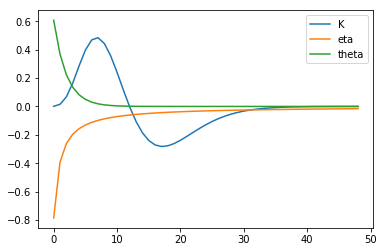

In [298]:
tt = np.arange(0.1,5,0.1) ###Kernel widths

alpha = 5
plt.plot(K(alpha,tt),label='K')

beta = 1
plt.plot(eta(beta,tt),label='eta')

taut = 0.2
plt.plot(Theta(taut,tt),label='theta')

th0 = 5  #normal threshold

plt.legend()

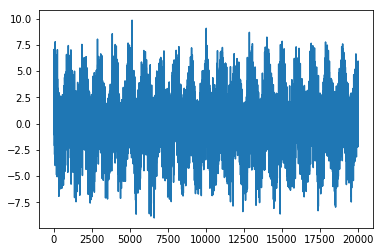

In [299]:
#stimulus
time = 200  #sec
dt = 0.01  #~10ms
t = np.arange(0,time,dt)

f = .1  #frequency  (5Hz for 200ms flickering)
In = np.cos(t*(2*np.pi)*f)*1 + 1*np.random.randn(len(t))
In = In*2

plt.plot(In)

In [306]:
us = np.zeros(len(t))  #membran potential
Ss = np.zeros(len(t))  #spike train
Ts = np.zeros(len(t))  #spike threshold

win = len(tt)
for ti in range(win,len(t)):
    #potential
    us[ti] = np.dot(In[ti-win:ti],np.flip(K(alpha,tt))) + np.dot(Ss[ti-win:ti],np.flip(eta(beta,tt)))
    #threshold
    Ts[ti] = th0 + np.dot(Ss[ti-win:ti],np.flip(Theta(taut,tt)))
    #spike
    Ss[ti] = NL(us[ti],Ts[ti])

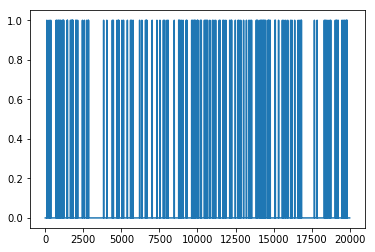

In [307]:
plt.plot(Ss)

In [308]:
## infer effective kernel
win = len(tt)  #kernel width
X = np.zeros((len(t)-win,win))

#design matrix
for xx in range(0,X.shape[0]):
    X[xx,:] = In[xx:xx+win]

#regression
Kest = np.linalg.inv(X.T @ X) @ X.T @ Ss[win:]

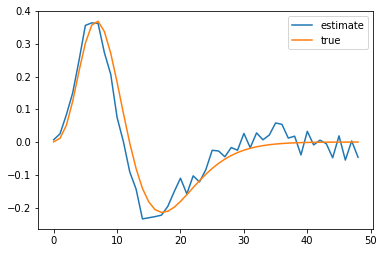

In [315]:
plt.plot(np.flip(Kest)/np.linalg.norm(Kest),label='estimate')
plt.plot(K(alpha,tt)/np.linalg.norm(K(alpha,tt)),label='true')
plt.legend()

In [312]:
us = np.zeros(len(t))  #membran potential
Ss = np.zeros(len(t))  #spike train
Ts = np.zeros(len(t))  #spike threshold

win = len(tt)
for ti in range(win,len(t)):
    #potential
    us[ti] = np.dot(In[ti-win:ti],np.flip(K(alpha,tt))) + np.dot(Ss[ti-win:ti],np.flip(eta(taue,tt)))
    #spike
    Ss[ti] = NL(us[ti],Ts[ti-1])
    #threshold
    Ts[ti] = th0 + np.dot(Ss[ti-win:ti],np.flip(Theta(taut,tt)))*Ts[ti-1]*Ss[ti]

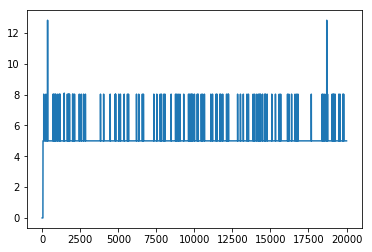

In [313]:
plt.plot(Ts)